In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-01-28 13:41:18.709327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 13:41:18.905763: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-28 13:41:19.593973: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

In [2]:
MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 

1 Physical GPUs, 1 Logical GPUs


2023-01-28 13:41:26.841007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 13:41:27.636916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [3]:
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

In [4]:
from local_utils import *

In [5]:
x_slice=slice(30,65,4)
y_slice=slice(50,85,4)
pattern = load("Koch_Meinhardt_2", x_slice, y_slice)

In [6]:
lb = pattern.dataset['lb']
ub = pattern.dataset['ub']

obs_inputs = pattern.dataset['obs_input']
obs_outputs = pattern.dataset['obs_output']
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs
ds = TINN_Dataset(tf.float32, obs_X, pde_X)

In [7]:
ds.sizes

array([162, 162])

array([1.37248605, 0.0159006 ])

In [18]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)
layers = [3, 128, 128, 128, 128, 128, 2]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
obs_loss = Observation_Loss(layers,
                            loss_grad_type=  Loss_Grad_Type.PINN)

norm_l2 = L2()

std_u, std_v = np.std(obs_outputs, axis=0)

@tf.function
def train_step(elements):
    with tf.GradientTape(persistent=True) as tape:        
        items = obs_loss.residual(pinn, elements[0])
        #items = [items[0]/std_u, items[1]/std_v]
        l2_items = norm_l2.reduce_norm(items)
        l2 = tf.reduce_sum(l2_items)        
        trainables = pinn.trainable_variables
        
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return l2_items


def epoch_callback(epoch, loss_samples):
    if epoch%10 == 0:
        print("################Callback called##################")

losses = tu.train(epochs=10000+1,
                  batch_size=81,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  epoch_callback=None)



Start of epoch 0
Loss value: 27.739398956298828, at epoch 0
Time taken: 2.46s

Start of epoch 1000
Loss value: 0.005204393062740564, at epoch 1000
Time taken: 23.42s

Start of epoch 2000
Loss value: 0.0008591153891757131, at epoch 2000
Time taken: 23.62s

Start of epoch 3000
Loss value: 0.0010016418527811766, at epoch 3000
Time taken: 23.71s

Start of epoch 4000
Loss value: 0.001317630521953106, at epoch 4000
Time taken: 23.45s

Start of epoch 5000
Loss value: 0.00041835286538116634, at epoch 5000
Time taken: 23.44s

Start of epoch 6000
Loss value: 0.00025252788327634335, at epoch 6000
Time taken: 23.94s
############################################
#       Early stop at 6488             
############################################


In [21]:
optimizer.lr.assign(2e-5)
losses2 = tu.train(epochs=10000+1,
                  batch_size=81,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=9e-6,
                  epoch_callback=None)


Start of epoch 0
Loss value: 9.652662993175909e-05, at epoch 0
Time taken: 0.15s

Start of epoch 1000
Loss value: 8.907351002562791e-05, at epoch 1000
Time taken: 23.29s

Start of epoch 2000
Loss value: 8.064341818680987e-05, at epoch 2000
Time taken: 23.30s

Start of epoch 3000
Loss value: 6.0594993556151167e-05, at epoch 3000
Time taken: 24.11s

Start of epoch 4000
Loss value: 4.120471567148343e-05, at epoch 4000
Time taken: 25.13s

Start of epoch 5000
Loss value: 2.6716446882346645e-05, at epoch 5000
Time taken: 23.89s

Start of epoch 6000
Loss value: 2.252072408737149e-05, at epoch 6000
Time taken: 23.68s

Start of epoch 7000
Loss value: 1.5844261724851094e-05, at epoch 7000
Time taken: 23.60s

Start of epoch 8000
Loss value: 1.242947382706916e-05, at epoch 8000
Time taken: 23.52s

Start of epoch 9000
Loss value: 1.1123861440864857e-05, at epoch 9000
Time taken: 23.60s
############################################
#       Early stop at 9314             
############################

In [22]:
pred = pinn.net(obs_inputs.astype(np.float32)).numpy()
np.sqrt(np.mean((pred - obs_outputs)**2))

0.00226638833670019

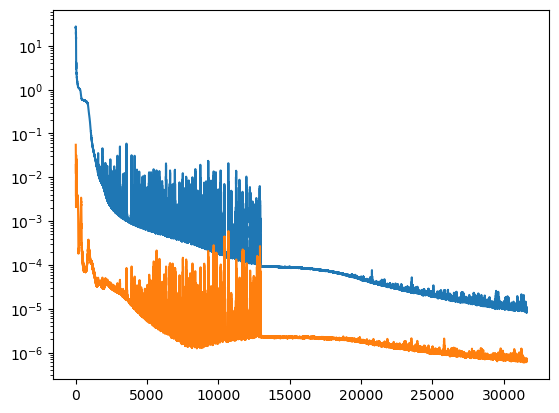

In [24]:
plt.plot(np.concatenate([losses, losses2]))
plt.yscale('log')